<a href="https://colab.research.google.com/github/Sporte25/Kaggle/blob/main/OpenAI__To_Z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>**Spatial Analysis and Predictive Modeling for the Discovery of Hidden Settlements in the Xingú River Basin**

---



## 1. Initial Analysis

### 1.1. Package Installation

In [1]:
!pip install rasterio
!pip install fiona
!pip install opendatasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 75.1 MB/s eta 0:00:00


### 1.2. Library Installation

In [2]:
import os
import opendatasets as od
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import uniform_filter # Para un filtro de suavizado
from shapely.geometry import Point # Para la generación de POIs

# ------------------------------------------------------------------------------
# MODO DE DEPURACIÓN (DEBUG MODE)
# ------------------------------------------------------------------------------
# Pon esto en True para ver mensajes detallados durante la generación de muestras negativas.
DEBUG_MODE = True

## 2. Data loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Ruta del archivos Google Drive
data_dir = '/content/drive/MyDrive/BD/Desafio_Xingu'

Mounted at /content/drive


### 2.1. Data Access

In [4]:
# Rutas a datos raster preprocesados (derivados topográficos)
dtm_path = os.path.join(data_dir, "Lidar", "dem", "DTM_Xingu_Final_UTM.tif")
slope_path = os.path.join(data_dir, "Lidar", "derivados", "Pendiente_Xingu_Final_UTM.tif")
curvature_path = os.path.join(data_dir, "Lidar", "derivados", "Curvatura_Xingu_Final_UTM.tif")
orientation_path = os.path.join(data_dir, "Lidar", "derivados", "Orientacion_Xingu_Final_UTM.tif")

# Las rutas a Hillshade y NDVI se mantienen solo para posible visualización, no para el modelo.
hillshade_path = os.path.join(data_dir, "Lidar", "derivados", "Hillshade_Xingu_Final_UTM_2.tif")
ndvi_path = os.path.join(data_dir, "Satélite", "indices", "NDVI_Xingu_Final_UTM.tif")

# Rutas a datos vectoriales (AOI y Sitios Conocidos)
xingu_basin_aoi_path = os.path.join(data_dir, "geodatabase", "AOI_Estudio_Final_UTM.shp")
known_sites_path = os.path.join(data_dir, "geodatabase", "Sitios_Xingu_Nuevo.shp")

# Rutas de salida para los resultados del script
output_results_dir = os.path.join(data_dir, "Resultados")
os.makedirs(output_results_dir, exist_ok=True) # Asegura que la carpeta de resultados existe

# Verificación de existencia de archivos requeridos para el MODELO
# Si algún archivo vital no se encuentra, el script se detendrá.
required_model_paths = {
    "DTM (Maestro Final)": dtm_path,
    "Pendiente (Final)": slope_path,
    "Curvatura (Final)": curvature_path,
    "Orientación (Final)": orientation_path,
    "AOI Estudio Final (.shp)": xingu_basin_aoi_path,
    "Sitios Conocidos Válidos (.shp)": known_sites_path
}

for name, path in required_model_paths.items():
    if not os.path.exists(path):
        print(f"¡ERROR FATAL! El archivo '{name}' NO SE ENCONTRÓ en la ruta: {path}")
        print(f"Para Shapefiles ({name}), asegúrate de que no solo el .shp, sino también todos los archivos")
        print(f"complementarios (.shx, .dbf, .prj, etc.) estén en la misma ubicación.")
        print("Por favor, verifica que los datos se hayan exportado y guardado correctamente desde ArcMap")
        print("y que las rutas en el script coincidan con la ubicación de tus archivos finales.")
        exit() # Sale del script si un archivo requerido para el modelo no se encuentra


## 3. Spatial Analysis


--- START: Step 3.1 - Exploratory Spatial Analysis ---
AOI ya está en el CRS proyectado esperado: EPSG:32721 (EPSG:32721).
AOI Verificación: is_projected=True, CRS=EPSG:32721
Sitios conocidos ya están en el CRS proyectado esperado: EPSG:32721 (EPSG:32721).
Sitios Conocidos Verificación: is_projected=True, CRS=EPSG:32721
DTM Maestro cargado. CRS: EPSG:32721 (EPSG:32721)
Rásteres de características (DTM, Pendiente, Curvatura, Orientación) cargados.
Hillshade cargado para visualización.
NDVI cargado para visualización.


/tmp/ipython-input-6-502817938.py:131: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


Imagen 'exploracion_inicial.png' guardada en /content/drive/MyDrive/BD/Desafio_Xingu/Resultados.


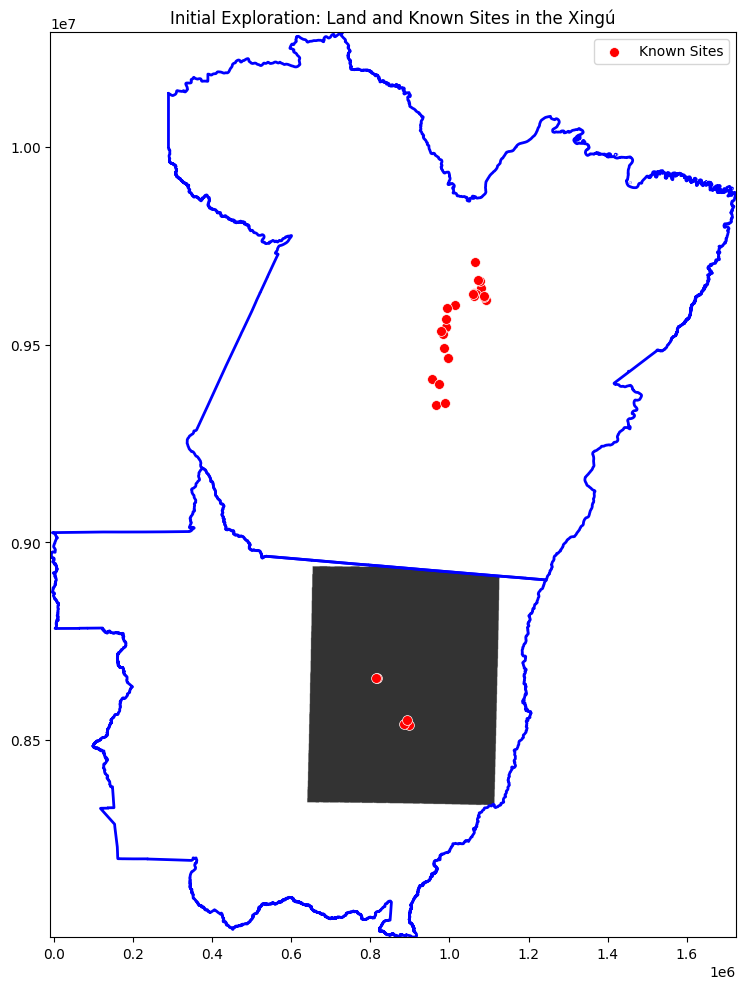

--- END: Step 3.1 - Exploratory Spatial Analysis ---


In [6]:

print("\n--- START: Step 3.1 - Exploratory Spatial Analysis ---")

# --- Carga de Capas Vectoriales (AOI y Sitios Conocidos) ---
try:
    # 3.1.1 Cargar el AOI (Área de Interés)
    xingu_basin_aoi = gpd.read_file(xingu_basin_aoi_path)

    # 3.1.2 Definir el CRS Objetivo para Proyección
    # Para análisis espaciales precisos en Python, se recomienda que todas las
    # capas estén en un CRS proyectado (en metros). Aquí asumimos
    # WGS 1984 UTM Zone 21S, que tiene el código EPSG:32721.
    target_crs_epsg = 32721

    # 3.1.3 Verificación y Reproyección del AOI
    # Se asegura que el AOI tenga un CRS definido y lo reproyecta al CRS objetivo si es necesario.
    if xingu_basin_aoi.crs is None:
        print("Advertencia: El AOI no tiene CRS definido. Asumiendo GCS_WGS_1984 (EPSG:4326) y reproyectando a UTM.")
        xingu_basin_aoi = xingu_basin_aoi.set_crs(epsg=4326, allow_override=True)

    if xingu_basin_aoi.crs.to_epsg() != target_crs_epsg:
        xingu_basin_aoi = xingu_basin_aoi.to_crs(epsg=target_crs_epsg)
        print(f"AOI reproyectado a {xingu_basin_aoi.crs.to_string()} (EPSG:{xingu_basin_aoi.crs.to_epsg()}).")
    else:
        print(f"AOI ya está en el CRS proyectado esperado: {xingu_basin_aoi.crs.to_string()} (EPSG:{xingu_basin_aoi.crs.to_epsg()}).")
    print(f"AOI Verificación: is_projected={xingu_basin_aoi.crs.is_projected}, CRS={xingu_basin_aoi.crs.to_string()}")

    # 3.1.4 Cargar Sitios Arqueológicos Conocidos
    known_sites = gpd.read_file(known_sites_path)

    # 3.1.5 Verificación y Reproyección de los Sitios Conocidos
    # Se asegura que los sitios conocidos tengan un CRS definido y los reproyecta al CRS objetivo.
    if known_sites.crs is None:
        print("Advertencia: Sitios conocidos sin CRS definido. Asumiendo GCS_WGS_1984 (EPSG:4326) y reproyectando a UTM.")
        known_sites = known_sites.set_crs(epsg=4326, allow_override=True)

    if known_sites.crs.to_epsg() != target_crs_epsg:
        known_sites = known_sites.to_crs(epsg=target_crs_epsg)
        print(f"Sitios conocidos reproyectados a {known_sites.crs.to_string()} (EPSG:{known_sites.crs.to_epsg()}).")
    else:
        print(f"Sitios conocidos ya están en el CRS proyectado esperado: {known_sites.crs.to_string()} (EPSG:{known_sites.crs.to_epsg()}).")
    print(f"Sitios Conocidos Verificación: is_projected={known_sites.crs.is_projected}, CRS={known_sites.crs.to_string()}")


except Exception as e:
    print(f"ERROR FATAL al cargar o reproyectar archivos vectoriales (AOI o Sitios Conocidos): {e}")
    print("Asegúrate de que tus Shapefiles (.shp, .shx, .dbf, .prj, etc.) son válidos y accesibles.")
    print("Se recomienda pre-procesar y reproyectar estos archivos en ArcMap a WGS 1984 UTM Zone 21S (EPSG:32721).")
    exit()

# --- Carga de Capas Ráster ---
# Se cargan el DTM maestro y sus derivados topográficos que se usarán como características
# para el modelo. Hillshade y NDVI se cargan solo para visualización si existen.
try:
    # 3.1.6 Cargar DTM Maestro
    with rasterio.open(dtm_path) as src_dtm_master:
        dtm_data = src_dtm_master.read(1) # Lee la primera banda del DTM
        dtm_profile = src_dtm_master.profile # Guarda los metadatos del DTM
        dtm_transform = src_dtm_master.transform # Guarda la transformación de coordenadas
        dtm_crs = src_dtm_master.crs # Guarda el CRS del DTM
        print(f"DTM Maestro cargado. CRS: {dtm_crs.to_string()} (EPSG:{dtm_crs.to_epsg() if dtm_crs.is_epsg_code else 'N/A'})")
        # src_for_indexing se usará para convertir coordenadas (X,Y) a índices de píxeles (fila, columna)
        src_for_indexing = src_dtm_master

    # 3.1.7 Cargar Rásteres Derivados (Características del Modelo)
    with rasterio.open(slope_path) as src_slope:
        slope = src_slope.read(1)
    with rasterio.open(curvature_path) as src_curvature:
        curvature = src_curvature.read(1)
    with rasterio.open(orientation_path) as src_orientation:
        orientation = src_orientation.read(1)
    print("Rásteres de características (DTM, Pendiente, Curvatura, Orientación) cargados.")

    # 3.1.8 Cargar Hillshade (Opcional, para visualización)
    hillshade_data = None
    if os.path.exists(hillshade_path):
        try:
            with rasterio.open(hillshade_path) as src_hillshade_data_load:
                hillshade_data = src_hillshade_data_load.read(1)
            print("Hillshade cargado para visualización.")
        except Exception as e_hill:
            print(f"Advertencia: No se pudo cargar Hillshade para visualización: {e_hill}")
    else:
        print("Hillshade no encontrado en la ruta especificada. La visualización inicial se hará con el DTM.")

    # 3.1.9 Cargar NDVI (Opcional, para visualización)
    ndvi_data = None
    if os.path.exists(ndvi_path):
        try:
            with rasterio.open(ndvi_path) as src_ndvi_data_load:
                ndvi_data = src_ndvi_data_load.read(1)
            print("NDVI cargado para visualización.")
        except Exception as e_ndvi:
            print(f"Advertencia: No se pudo cargar NDVI para visualización: {e_ndvi}")
    else:
        print("NDVI no encontrado en la ruta especificada.")

except Exception as e:
    print(f"ERROR FATAL al cargar rásteres. Asegúrate de que los archivos TIFF son válidos, accesibles,")
    print(f"y que sus propiedades espaciales son consistentes y alineadas: {e}")
    exit()

# --- Verificación Final de Consistencia de CRS entre Vector y Ráster ---
# Confirma que el CRS de las capas vectoriales y ráster (el DTM maestro)
# es el mismo. Las desalineaciones aquí causan errores de superposición.
if xingu_basin_aoi.crs != dtm_crs:
    print(f"¡ERROR CRÍTICO de CRS! El CRS del AOI ({xingu_basin_aoi.crs.to_string()}) NO COINCIDE con el CRS del DTM ({dtm_crs.to_string()}).")
    print("Este problema DEBE resolverse en ArcMap reproyectando el AOI al CRS del DTM (WGS 1984 UTM Zone 21S).")
    exit()
if known_sites.crs != dtm_crs:
    print(f"¡ERROR CRÍTICO de CRS! El CRS de Sitios Conocidos ({known_sites.crs.to_string()}) NO COINCIDE con el CRS del DTM ({dtm_crs.to_string()}).")
    print("Este problema DEBE resolverse en ArcMap reproyectando los Sitios Conocidos al CRS del DTM (WGS 1984 UTM Zone 21S).")
    exit()

# --- 3.1.10 Visualización Exploratoria Inicial ---
# Muestra una vista general del área de estudio. Utiliza el Hillshade (si está disponible)
# como mapa base para el terreno, superponiendo el AOI y los sitios conocidos.
fig, ax = plt.subplots(figsize=(10, 10))
if hillshade_data is not None:
    # Usa rasterio.plot.show para dibujar el Hillshade como imagen de fondo
    with rasterio.open(hillshade_path) as src_hill_plot:
        show(src_hill_plot, ax=ax, cmap='gray', adjust='linear', alpha=0.8, title="Terreno (Hillshade)")
else:
    # Si Hillshade no está disponible, utiliza el DTM como base
    with rasterio.open(dtm_path) as src_dtm_plot:
        show(src_dtm_plot, ax=ax, cmap='terrain', adjust='linear', alpha=0.8, title="Terreno (DTM)")
    print("Visualización inicial usando DTM ya que Hillshade no está disponible.")

xingu_basin_aoi.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, label="AOI de Procesamiento")
known_sites.plot(ax=ax, marker='o', color='red', markersize=50, label="Known Sites", edgecolor='white', linewidth=0.5)
ax.set_title("Initial Exploration: Land and Known Sites in the Xingú")
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_results_dir, "exploracion_inicial.png"))
print(f"Imagen 'exploracion_inicial.png' guardada en {output_results_dir}.")
plt.show()
print("--- END: Step 3.1 - Exploratory Spatial Analysis ---")

## 4. Feature Extraction and Preparation of the Training Dataset

In [7]:

print("\n--- START: Step 3.2 - Feature Extraction and Preparation of the Training Dataset ---")

# --- 4.2.1 Verificación de Consistencia de Formas de Rásteres para el Modelo ---
# Es CRÍTICO que todas las capas ráster que se usarán como características en el
# modelo (DTM, Pendiente, Curvatura, Orientación) tengan exactamente la misma
# forma (mismo número de filas y columnas, y misma resolución de píxel).
print(f"Forma DTM: {dtm_data.shape}")
print(f"Forma Pendiente: {slope.shape}")
print(f"Forma Curvatura: {curvature.shape}")
print(f"Forma Orientación: {orientation.shape}")

if not (dtm_data.shape == slope.shape == curvature.shape == orientation.shape):
    print("¡ERROR FATAL! Los rásteres de características principales NO TIENEN LA MISMA FORMA.")
    print("Asegúrate de que todos los rásteres se hayan exportado desde ArcMap con la")
    print("MISMA EXTENSIÓN, el MISMO TAMAÑO DE CELDAS y el MISMO PIXEL TYPE (32_BIT_FLOAT).")
    exit()

# --- 4.2.2 Extracción de Valores de Píxeles para Sitios Positivos (Asentamientos Conocidos) ---
# Para cada sitio arqueológico conocido, se extrae el valor del píxel
# correspondiente de cada capa ráster. Estos puntos se etiquetan como '1' (positivo).
known_site_coords = [(p.x, p.y) for p in known_sites.geometry]
positive_features = []
nodata_value_dtm = dtm_profile['nodata'] # Valor de no-data del DTM (se asume que es el mismo para todas las capas)

for x, y in known_site_coords:
    # Convierte las coordenadas X, Y del sitio a índices de fila y columna en el ráster
    row, col = src_for_indexing.index(x, y)

    # Verifica que el píxel esté dentro de los límites del ráster y que NO sea un valor 'no-data'
    # en NINGUNA de las capas de características del modelo.
    if (0 <= row < dtm_data.shape[0] and 0 <= col < dtm_data.shape[1] and
        dtm_data[row, col] != nodata_value_dtm and
        slope[row, col] != nodata_value_dtm and
        curvature[row, col] != nodata_value_dtm and
        orientation[row, col] != nodata_value_dtm):

        positive_features.append({
            'dtm': dtm_data[row, col],
            'slope': slope[row, col],
            'curvature': curvature[row, col],
            'orientation': orientation[row, col],
            'label': 1 # Etiqueta '1' para un sitio arqueológico conocido
        })
    else:
        if DEBUG_MODE: print(f"DEBUG: Sitio conocido en ({x:.2f}, {y:.2f}) no pudo extraer características (fuera de límites o en 'no-data').")
print(f"Se extrajeron características para {len(positive_features)} sitios conocidos (positivos).")

# --- 4.2.3 Generación de Sitios Negativos Aleatorios ---
# Se generan puntos aleatorios dentro del AOI de estudio. Estos puntos representan
# áreas donde se asume que NO hay asentamientos ("no-sitios") y se etiquetan como '0'.
# Se aplican reglas para evitar muestrear cerca de sitios conocidos o en áreas 'no-data'.
num_negative_samples = len(positive_features) * 5 # Se intenta generar 5 veces más muestras negativas que positivas
if num_negative_samples == 0 and len(positive_features) > 0:
    num_negative_samples = 28 # Caso especial: si solo hay un sitio positivo, asegura al menos 5 negativos.
elif num_negative_samples == 0 and len(positive_features) == 0:
    print("ERROR FATAL: No hay sitios conocidos (positivos) para generar muestras negativas.")
    print("Asegúrate de que la capa 'Sitios_Arqueologicos_Xingu_UTM.shp' contenga puntos")
    print("y que estos caigan sobre áreas de datos válidos en tus rásteres principales.")
    exit() # El script no puede continuar sin sitios positivos.

negative_features = []

# Crear un área de exclusión (buffer) alrededor de los sitios conocidos
# para evitar muestrear "no-sitios" demasiado cerca de los "sitios" reales.
buffer_distance_m = 100 # Distancia en metros para el buffer de exclusión.
known_sites_buffer = gpd.GeoSeries([]) # Inicializar como una GeoSeries vacía

if not known_sites.empty and known_sites.crs.is_projected:
    known_sites_buffer = known_sites.buffer(buffer_distance_m)
    if DEBUG_MODE: print(f"DEBUG: Buffer de {buffer_distance_m} metros creado alrededor de los sitios conocidos.")
elif not known_sites.empty and not known_sites.crs.is_projected:
    print("Advertencia: Sitios conocidos no proyectados para buffer. Usando un buffer pequeño en grados (menos preciso).")
    known_sites_buffer = known_sites.buffer(0.001) # Buffer pequeño en grados como fallback
else:
    if DEBUG_MODE: print("DEBUG: No hay sitios conocidos para crear el buffer de exclusión.")

# Límites de la extensión del AOI para la generación aleatoria de puntos
minx, miny, maxx, maxy = xingu_basin_aoi.total_bounds
counter = 0 # Contador de muestras negativas exitosamente generadas
max_attempts = num_negative_samples * 10000 # Límite máximo de intentos para evitar bucles infinitos
attempts = 0 # Contador de intentos realizados

print(f"Intentando generar {num_negative_samples} sitios negativos (máx. intentos: {max_attempts})...")
while counter < num_negative_samples and attempts < max_attempts:
    rand_x = np.random.uniform(minx, maxx) # Genera una coordenada X aleatoria
    rand_y = np.random.uniform(miny, maxy) # Genera una coordenada Y aleatoria

    point_geom = Point(rand_x, rand_y) # Crea un objeto de punto Shapely

    # 1. Verificar si el punto está dentro del AOI de estudio
    is_within_aoi = xingu_basin_aoi.geometry.intersects(point_geom).any()
    if not is_within_aoi:
        if DEBUG_MODE: print(f"DEBUG: Intento {attempts+1}: Punto fuera de AOI.")
        attempts += 1
        continue # Pasa al siguiente intento

    # 2. Verificar si el punto está demasiado cerca de un sitio conocido (intersecta el buffer)
    is_too_close_to_known_site = known_sites_buffer.intersects(point_geom).any()
    if is_too_close_to_known_site:
        if DEBUG_MODE: print(f"DEBUG: Intento {attempts+1}: Punto demasiado cerca de sitio conocido.")
        attempts += 1
        continue # Pasa al siguiente intento

    # 3. Convertir coordenadas a índices de fila/columna del ráster principal (DTM)
    row, col = src_for_indexing.index(rand_x, rand_y)

    # 4. Verificar si el píxel está dentro de los límites del ráster y NO es un valor 'no-data'
    # para TODAS las capas de características del modelo.
    if not (0 <= row < dtm_data.shape[0] and 0 <= col < dtm_data.shape[1]):
        if DEBUG_MODE: print(f"DEBUG: Intento {attempts+1}: Punto fuera de límites del raster (índices {row},{col}).")
        attempts += 1
        continue

    # Verifica que el píxel no sea 'no-data' en ninguna de las características del modelo.
    if (dtm_data[row, col] == nodata_value_dtm or
        slope[row, col] == nodata_value_dtm or
        curvature[row, col] == nodata_value_dtm or
        orientation[row, col] == nodata_value_dtm):
        if DEBUG_MODE: print(f"DEBUG: Intento {attempts+1}: Punto sobre píxel 'no-data'.")
        attempts += 1
        continue

    # Si todas las verificaciones pasan, añade el punto a las características negativas
    negative_features.append({
        'dtm': dtm_data[row, col],
        'slope': slope[row, col],
        'curvature': curvature[row, col],
        'orientation': orientation[row, col],
        'label': 0 # Etiqueta '0' para un no-sitio
    })
    counter += 1 # Incrementa el contador de muestras negativas exitosas
    attempts += 1 # Incrementa el contador de intentos totales

print(f"Se extrajeron características para {len(negative_features)} sitios negativos (intentos totales: {attempts}).")
if counter < num_negative_samples:
    print(f"Advertencia: No se pudieron generar todos los {num_negative_samples} sitios negativos deseados. Se generaron {counter}.")


# --- 4.2.4 Combinar y Preparar el Dataset Final para el Modelo ---
# Se unen las características de los sitios positivos y negativos en un
# único DataFrame de Pandas. Se definen las características (X) y las etiquetas (y).
if not positive_features:
    print("ERROR FATAL: No se pudieron extraer características para SITIOS POSITIVOS.")
    print("Esto puede deberse a que los sitios conocidos están fuera de la extensión de los rasters,")
    print("o caen en áreas de 'no-data' en todos los rasters. Revisa tus datos de entrada y tu AOI de estudio.")
    exit()

if not negative_features:
    print("ERROR FATAL: No se pudieron extraer características para SITIOS NEGATIVOS.")
    print("Esto puede deberse a que la generación de puntos aleatorios falló (ej., AOI muy pequeño,")
    print("buffer de sitios conocidos muy grande, o mucha área 'no-data' en los rasters).")
    print("Revisa tu AOI, el tamaño del buffer y la calidad de tus rásteres de entrada.")
    exit()

all_features = pd.DataFrame(positive_features + negative_features)
# Define las características (variables independientes) para el modelo
X = all_features[['dtm', 'slope', 'curvature', 'orientation']]
# Define la etiqueta (variable dependiente)
y = all_features['label']

print(f"Dimensiones del dataset de entrenamiento (X): {X.shape}")
print(f"Conteo de etiquetas (y):\n{y.value_counts()}")

# --- 4.2.5 Dividir Datos en Conjuntos de Entrenamiento y Prueba ---
# Se divide el dataset en un conjunto de entrenamiento (para que el modelo aprenda)
# y un conjunto de prueba (para evaluar qué tan bien generaliza el modelo).
# 'stratify=y' es crucial para asegurar que la proporción de clases (0 y 1)
# se mantenga en ambos conjuntos, especialmente útil con clases desequilibradas.
if len(y.unique()) < 2:
    print("ERROR FATAL: El dataset de entrenamiento no tiene suficientes clases (solo una clase presente: positivos O negativos).")
    print("Esto significa que el proceso de muestreo no logró obtener ambos tipos de muestras. Revisa tus datos y el muestreo.")
    exit()

min_samples_per_class = y.value_counts().min()
if min_samples_per_class < 2:
    print(f"Advertencia: Algunas clases tienen muy pocas muestras ({min_samples_per_class}) para una división estratificada robusta.")
    if min_samples_per_class == 1:
        print("ERROR FATAL: Solo una muestra en la clase minoritaria. No se puede realizar train_test_split con stratify.")
        print("Necesitas al menos 2 sitios positivos y 2 negativos para una división mínimamente estratificada y que el modelo pueda aprender.")
        exit()
    else:
        # Ajuste heurístico para datasets muy pequeños que apenas permiten estratificación.
        total_samples = y.value_counts().sum()
        test_size_adjusted = max(0.1, 1 / total_samples) # Asegura al menos una muestra en el conjunto de prueba
        test_size_adjusted = min(0.5, test_size_adjusted) # No más del 50% para el conjunto de prueba
        print(f"Test size ajustado a: {test_size_adjusted:.2f} debido a la escasez de muestras para estratificación.")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_adjusted, random_state=42, stratify=y)
else:
    # División estándar con 20% para el conjunto de prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dimensiones del conjunto de entrenamiento: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Dimensiones del conjunto de prueba: X_test={X_test.shape}, y_test={y_test.shape}")
print("--- END: Step 3.2 - Feature Extraction and Preparation of the Training Dataset ---")



--- START: Step 3.2 - Feature Extraction and Preparation of the Training Dataset ---
Forma DTM: (4884, 3698)
Forma Pendiente: (4884, 3698)
Forma Curvatura: (4884, 3698)
Forma Orientación: (4884, 3698)
DEBUG: Sitio conocido en (1064312.56, 9708155.99) no pudo extraer características (fuera de límites o en 'no-data').
DEBUG: Sitio conocido en (997263.79, 9465596.53) no pudo extraer características (fuera de límites o en 'no-data').
DEBUG: Sitio conocido en (997263.79, 9465596.53) no pudo extraer características (fuera de límites o en 'no-data').
DEBUG: Sitio conocido en (1092864.34, 9613673.15) no pudo extraer características (fuera de límites o en 'no-data').
DEBUG: Sitio conocido en (1092864.34, 9613673.15) no pudo extraer características (fuera de límites o en 'no-data').
DEBUG: Sitio conocido en (1061718.11, 9629380.37) no pudo extraer características (fuera de límites o en 'no-data').
DEBUG: Sitio conocido en (1078523.09, 9643721.72) no pudo extraer características (fuera de límite

## 5. Training and Evaluation of the Classification Model


--- START: Step 3.3 - Training and Evaluation of the Classification Model ---
Training Random Forest modelt...
Successfully trained model.

Model accuracy on the test set: 0.83

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.00      0.00      0.00         1

    accuracy                           0.83         6
   macro avg       0.42      0.50      0.45         6
weighted avg       0.69      0.83      0.76         6


Importance of the characteristics:
dtm            0.457864
slope          0.236425
orientation    0.192622
curvature      0.113089
dtype: float64


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Imagen 'Importance_characteristics.png' guardada en /content/drive/MyDrive/BD/Desafio_Xingu/Resultados.


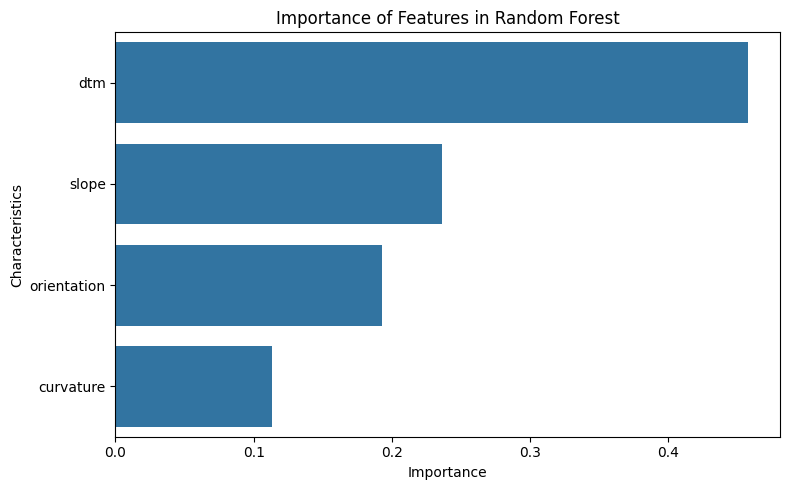

--- END: Step 3.3 - Training and Evaluation of the Classification Model ---


In [9]:
print("\n--- START: Step 3.3 - Training and Evaluation of the Classification Model ---")

print("Training Random Forest modelt...")
# 5.3.1 Configuración y Entrenamiento del Modelo Random Forest
# RandomForestClassifier es un algoritmo de ensamblaje (ensemble) que construye
# múltiples árboles de decisión y combina sus predicciones.
# n_estimators=100: Número de árboles de decisión en el bosque.
# random_state=42: Semilla para reproducibilidad de los resultados.
# class_weight='balanced': Ajusta automáticamente los pesos de las clases
# inversamente a las frecuencias de las clases, útil para manejar desequilibrios
# donde una clase (ej., sitios positivos) es mucho menos frecuente que la otra.
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
print("Successfully trained model.")

# --- 5.3.2 Evaluación del Modelo ---
# Se predice sobre el conjunto de prueba (datos que el modelo no ha visto
# durante el entrenamiento) para estimar qué tan bien generaliza el modelo
# a nuevos datos.
if not X_test.empty:
    y_pred = model.predict(X_test)
    print(f"\nModel accuracy on the test set: {accuracy_score(y_test, y_pred):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
else:
    print("Warning: The test set is empty. Full evaluation of the model cannot be performed..")

# --- 5.3.3 Importancia de las Características ---
# Muestra qué características (DTM, Pendiente, Curvatura, Orientación) fueron
# más influyentes (aportaron más al poder predictivo) para el modelo.
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nImportance of the characteristics:")
print(feature_importances)

# --- 5.3.4 Visualización de la Importancia de las Características ---
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Importance of Features in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Characteristics')
plt.tight_layout()
plt.savefig(os.path.join(output_results_dir, "Importance_characteristics.png"))
print(f"Imagen 'Importance_characteristics.png' guardada en {output_results_dir}.")
plt.show()
print("--- END: Step 3.3 - Training and Evaluation of the Classification Model ---")


## Suitability Modeling of Sites (Application of the Model)


--- START: Step 3.4 - Suitability Modeling of Sites ---
Número de píxeles válidos para predecir en toda la extensión: 1273407


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Mapa de idoneidad guardado en: /content/drive/MyDrive/BD/Desafio_Xingu/Resultados/Xingu_Suitability_Map.tif


/tmp/ipython-input-10-396427464.py:97: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


Imagen 'mapa_idoneidad.png' guardada en /content/drive/MyDrive/BD/Desafio_Xingu/Resultados.


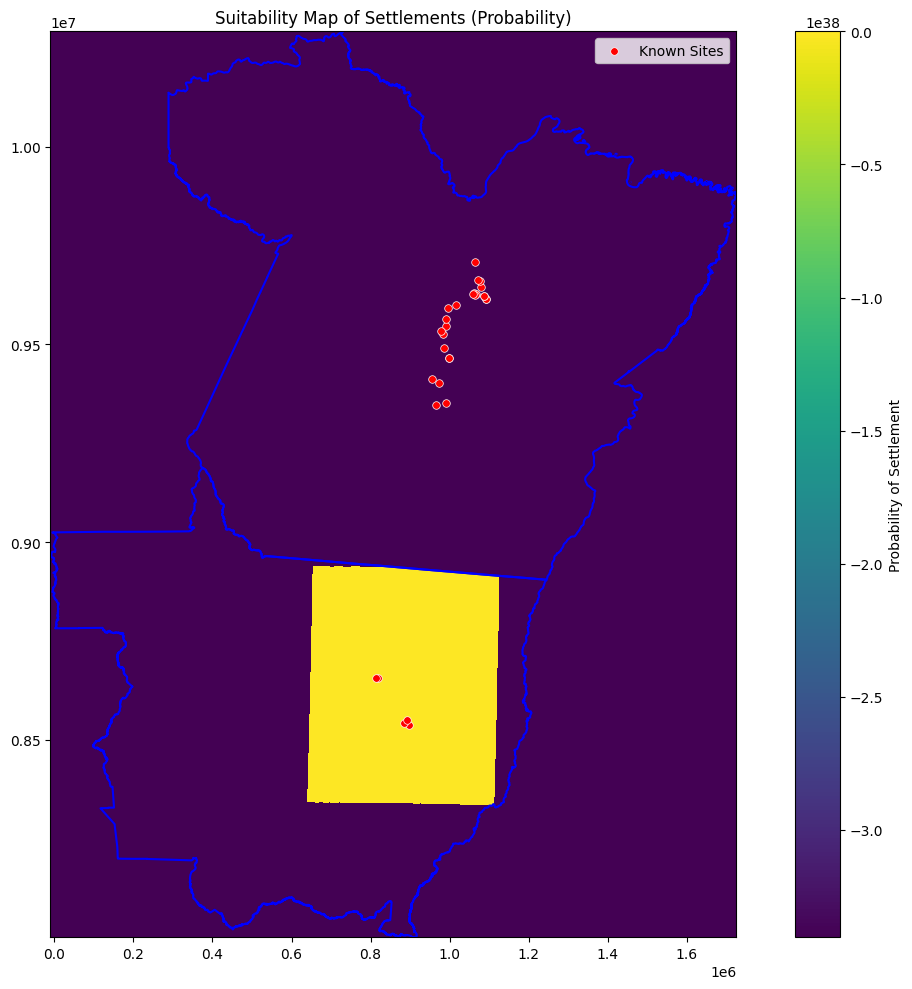

--- END: Step 3.4 - Suitability Modeling of Sites ---


In [10]:
print("\n--- START: Step 3.4 - Suitability Modeling of Sites ---")

# 6.4.1 Leer las Capas Ráster Completas para Predicción
# Se cargan nuevamente los rásteres completos (ya recortados y alineados)
# para aplicar el modelo a cada píxel de toda el área de estudio.
try:
    with rasterio.open(dtm_path) as src_dtm_pred:
        profile_dtm_pred = src_dtm_pred.profile # Guarda el perfil para la salida
        dtm_all = src_dtm_pred.read(1)
    with rasterio.open(slope_path) as src_slope_pred:
        slope_all = src_slope_pred.read(1)
    with rasterio.open(curvature_path) as src_curvature_pred:
        curvature_all = src_curvature_pred.read(1)
    with rasterio.open(orientation_path) as src_orientation_pred:
        orientation_all = src_orientation_pred.read(1)

    # 6.4.2 Crear una Máscara de Píxeles Válidos
    # Se genera una máscara booleana para identificar solo los píxeles donde
    # todas las capas de características tienen datos válidos (no son 'no-data').
    # Esto evita errores de predicción en áreas vacías o de borde.
    nodata_value = profile_dtm_pred['nodata'] # Obtiene el valor 'no-data' del DTM principal
    valid_pixels_mask = (dtm_all != nodata_value) & \
                        (slope_all != nodata_value) & \
                        (curvature_all != nodata_value) & \
                        (orientation_all != nodata_value)

    # 6.4.3 Preparar las Características para la Predicción
    # Se apilan los valores de las características de los píxeles válidos en
    # un array 2D, con filas = píxeles y columnas = características.
    prediction_features = np.vstack([
        dtm_all[valid_pixels_mask],
        slope_all[valid_pixels_mask],
        curvature_all[valid_pixels_mask],
        orientation_all[valid_pixels_mask]
    ]).T # La transpuesta es crucial para el formato esperado por sklearn

    print(f"Número de píxeles válidos para predecir en toda la extensión: {prediction_features.shape[0]}")

    if prediction_features.shape[0] == 0:
        print("¡ERROR FATAL! No hay píxeles válidos para realizar la predicción del mapa de idoneidad.")
        print("Verifica si tus rásteres están completamente compuestos por 'no-data' o si no se superponen entre sí.")
        exit()

    # 6.4.4 Predecir Probabilidades de Idoneidad
    # El modelo predice la probabilidad de que cada píxel pertenezca a la clase
    # "asentamiento" (label 1).
    predicted_probabilities = model.predict_proba(prediction_features)[:, 1]

    # 6.4.5 Crear el Mapa de Idoneidad
    # Se inicializa un nuevo array con la misma forma que el DTM original,
    # rellenándolo con el valor 'no-data'. Luego, se insertan las probabilidades
    # predichas solo en las ubicaciones de los píxeles válidos.
    suitability_map = np.full(dtm_all.shape, nodata_value, dtype=np.float32)
    suitability_map[valid_pixels_mask] = predicted_probabilities

    # --- 6.4.6 Guardar el Mapa de Idoneidad como Archivo TIFF ---
    # Define la ruta de salida para el nuevo ráster y actualiza el perfil
    # con los metadatos correctos para la salida del mapa de probabilidad.
    output_suitability_path = os.path.join(output_results_dir, "Xingu_Suitability_Map.tif")

    profile_suitability = profile_dtm_pred.copy()
    profile_suitability.update({
        'dtype': rasterio.float32, # El mapa de idoneidad son probabilidades (valores flotantes entre 0 y 1)
        'count': 1, # Es una sola banda
        'transform': src_dtm_pred.transform, # Mantiene la misma transformación que el DTM original
        'height': dtm_all.shape[0],
        'width': dtm_all.shape[1],
        'nodata': nodata_value # Mantiene el mismo valor 'no-data'
    })

    with rasterio.open(output_suitability_path, 'w', **profile_suitability) as dst:
        dst.write(suitability_map, 1) # Escribe el mapa de idoneidad en la primera banda

    print(f"Mapa de idoneidad guardado en: {output_suitability_path}")

    # --- 6.4.7 Visualización del Mapa de Idoneidad ---
    # Se genera una visualización del mapa de probabilidad de idoneidad,
    # superponiendo el AOI y los sitios conocidos para contextualización.
    plt.figure(figsize=(12, 10))
    with rasterio.open(output_suitability_path) as src_suit:
        suitability_data_to_plot = src_suit.read(1) # Lee los datos del ráster del mapa de idoneidad
        # Define la extensión del mapa para imshow, usando los límites del ráster
        extent = [src_suit.bounds.left, src_suit.bounds.right, src_suit.bounds.bottom, src_suit.bounds.top]

        ax_plot = plt.gca() # Obtiene los ejes actuales de Matplotlib para dibujar
        # Usa imshow para dibujar el mapa de idoneidad.
        # 'origin="upper"' y 'extent' son clave para georreferenciar correctamente la imagen.
        im_plot = ax_plot.imshow(suitability_data_to_plot, cmap='viridis', extent=extent, origin='upper', aspect='auto', interpolation='nearest')

        ax_plot.set_title('Suitability Map of Settlements (Probability)')
        # Añade la barra de color, vinculándola directamente al objeto de imagen ('im_plot')
        plt.colorbar(im_plot, ax=ax_plot, label='Probability of Settlement')

    # Superpone las capas vectoriales para referencia
    xingu_basin_aoi.plot(ax=plt.gca(), facecolor='none', edgecolor='blue', linewidth=1.5, label="AOI de Estudio")
    known_sites.plot(ax=plt.gca(), marker='o', color='red', markersize=30, label="Known Sites", edgecolor='white', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_results_dir, "mapa_idoneidad.png"))
    print(f"Imagen 'mapa_idoneidad.png' guardada en {output_results_dir}.")
    plt.show()

except Exception as e:
    print(f"Error durante el modelado de idoneidad (Paso 3.4): {e}")
    print("Esto puede deberse a problemas con los rásteres de entrada o la visualización.")
print("--- END: Step 3.4 - Suitability Modeling of Sites ---")

## 7. Generation of Points of Interest (POIs)


--- START: Step 3.5 - Generation of Points of Interest (POIs)) ---


/tmp/ipython-input-11-3881453768.py:39: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  pois_gdf.to_file(output_pois_path)
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'probability' to 'probabilit'
  ogr_write(


Se generaron 43439 Puntos de Interés (POIs) con probabilidad > 80%.
POIs guardados en: /content/drive/MyDrive/BD/Desafio_Xingu/Resultados/Xingu_Potential_POIs.shp


/usr/local/lib/python3.11/dist-packages/geopandas/plotting.py:306: UserWarning: You passed a edgecolor/edgecolors ('darkgreen') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  collection = ax.scatter(x, y, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
/tmp/ipython-input-11-3881453768.py:60: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


Imagen 'pois_generados.png' guardada en /content/drive/MyDrive/BD/Desafio_Xingu/Resultados.


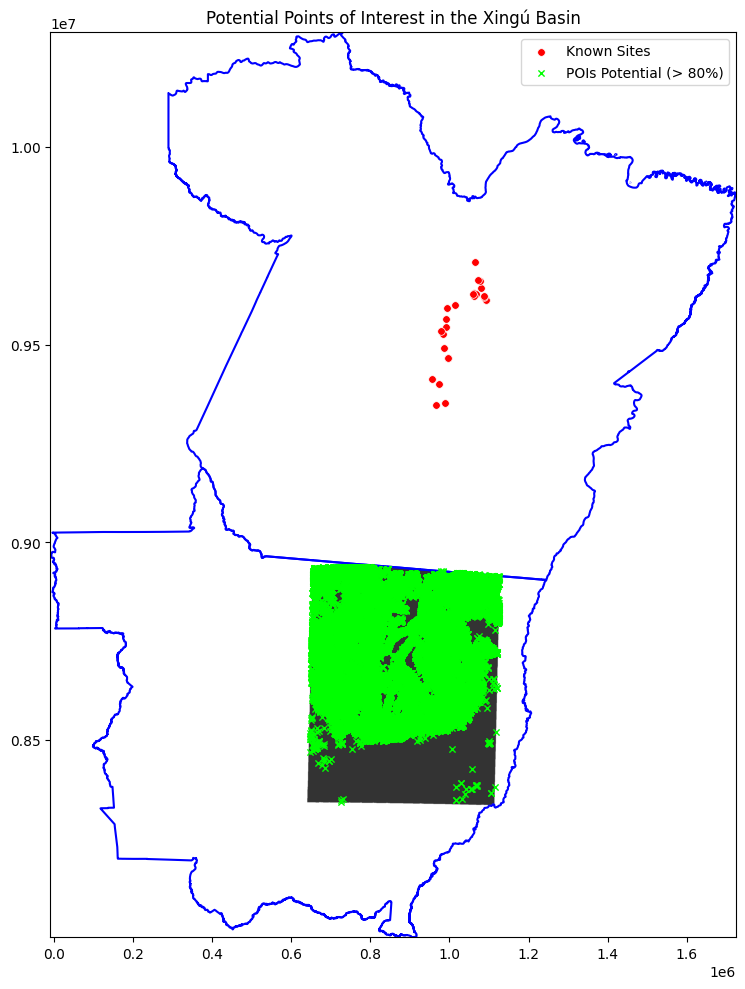

--- END: Step 3.5 - Generation of Points of Interest (POIs) ---


In [11]:

print("\n--- START: Step 3.5 - Generation of Points of Interest (POIs)) ---")

if not os.path.exists(output_suitability_path):
    print(f"ERROR: No se encontró el mapa de idoneidad en '{output_suitability_path}'. No se pueden generar POIs.")
    print("Asegúrate de que el Paso 3.4 se ejecutó correctamente y generó el archivo TIFF.")
    exit()

# Cargar el mapa de idoneidad generado en el paso anterior
with rasterio.open(output_suitability_path) as src_suit:
    suitability_data = src_suit.read(1)
    suitability_profile = src_suit.profile
    suitability_transform = src_suit.transform
    suitability_crs = src_suit.crs

threshold = 0.80 # Umbral de probabilidad para considerar un píxel como POI potencial.
# Puedes ajustar este umbral: un valor más alto genera menos POIs pero más "seguros",
# un valor más bajo genera más POIs pero con más posibles falsos positivos.

# Identifica los píxeles donde la probabilidad de idoneidad supera el umbral
# y donde no hay valores 'no-data'.
potential_poi_mask = (suitability_data > threshold) & (suitability_data != suitability_profile['nodata'])

# Obtiene los índices de fila y columna de los píxeles que cumplen la condición
rows, cols = np.where(potential_poi_mask)

# Convierte los píxeles identificados en objetos de punto geográfico (Shapely Point).
poi_points = []
for r, c in zip(rows, cols):
    x, y = rasterio.transform.xy(suitability_transform, r, c) # Obtiene las coordenadas (X, Y) del centro del píxel
    poi_points.append({'geometry': Point(x, y), 'probability': suitability_data[r, c]})

if poi_points:
    # Crea un GeoDataFrame a partir de los puntos identificados, asignándoles el CRS.
    pois_gdf = gpd.GeoDataFrame(poi_points, crs=suitability_crs)
    output_pois_path = os.path.join(output_results_dir, "Xingu_Potential_POIs.shp")

    # Guarda los POIs como un Shapefile.
    os.makedirs(os.path.dirname(output_pois_path), exist_ok=True) # Asegura que el directorio de salida existe
    pois_gdf.to_file(output_pois_path)
    print(f"Se generaron {len(pois_gdf)} Puntos de Interés (POIs) con probabilidad > {threshold*100:.0f}%.")
    print(f"POIs guardados en: {output_pois_path}")

    # --- Visualización de POIs sobre el Terreno ---
    # Se muestra el mapa de los POIs superpuestos sobre una base de terreno
    # (Hillshade si está disponible, DTM si no), junto con el AOI y los sitios conocidos.
    plt.figure(figsize=(12, 10))
    if hillshade_data is not None:
        with rasterio.open(hillshade_path) as src_hill_plot_final:
            show(src_hill_plot_final, cmap='gray', ax=plt.gca(), adjust='linear', alpha=0.8)
    else:
        with rasterio.open(dtm_path) as src_dtm_plot_final:
            show(src_dtm_plot_final, ax=plt.gca(), cmap='terrain', adjust='linear', alpha=0.8)
        print("Hillshade no disponible para visualización de POIs. La visualización se realizó usando el DTM.")

    # Superpone las capas vectoriales para referencia
    xingu_basin_aoi.plot(ax=plt.gca(), facecolor='none', edgecolor='blue', linewidth=1.5, label="AOI de Estudio")
    known_sites.plot(ax=plt.gca(), marker='o', color='red', markersize=30, label="Known Sites", edgecolor='white', linewidth=0.5)
    pois_gdf.plot(ax=plt.gca(), marker='x', color='lime', markersize=20, label=f"POIs Potential (> {threshold*100:.0f}%)", edgecolor='darkgreen', linewidth=1)
    plt.title('Potential Points of Interest in the Xingú Basin')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_results_dir, "pois_generados.png"))
    print(f"Imagen 'pois_generados.png' guardada en {output_results_dir}.")
    plt.show()

else:
    print(f"No se generaron POIs con el umbral dado ({threshold*100:.0f}%).")
    print("Intenta reducir el umbral de probabilidad si esperas encontrar más POIs o revisa los datos de entrada y el modelo.")

print("--- END: Step 3.5 - Generation of Points of Interest (POIs) ---")